In [1]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
%pip install xgboost
import xgboost as xgb
import optuna
import warnings
warnings.filterwarnings('ignore')

# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
sns.set_palette("viridis")
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Load and preprocess data
df = pd.read_csv('data/power_consumption_data.csv')
df=df.ffill()  # Forward fill missing values
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

In [3]:
# Feature engineering
df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
df['Heating_degree_days'] = np.maximum(15 - df['temp'], 0)
df['Cooling_degree_days'] = np.maximum(df['temp'] - 24, 0)

# Create time series dataset
ts_data = df[['Global_active_power']].copy()

# Split data (last 3 months for test)
split_date = '2009-09-01'
train = ts_data[ts_data.index < split_date]
test = ts_data[ts_data.index >= split_date]

print(f"Train size: {train.shape[0]} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"Test size: {test.shape[0]} days ({test.index.min().date()} to {test.index.max().date()})")

Train size: 989 days (2006-12-17 to 2009-08-31)
Test size: 452 days (2009-09-01 to 2010-11-26)


In [5]:
# === ARIMA Hyperparameter Tuning with Optuna ===
def arima_objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        aic = model_fit.aic
        return aic
    except:
        return float('inf')

# Optimize ARIMA parameters
arima_study = optuna.create_study(direction='minimize')
arima_study.optimize(arima_objective, n_trials=50)

# Get best parameters
best_arima_params = arima_study.best_params
print(f"Best ARIMA parameters: {best_arima_params}")

# Train and evaluate ARIMA
arima_model = ARIMA(train, order=(
    best_arima_params['p'], 
    best_arima_params['d'], 
    best_arima_params['q']
))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

[I 2025-05-30 09:13:19,364] A new study created in memory with name: no-name-2824c7e4-8546-4b56-92f9-62232b961270
[I 2025-05-30 09:13:20,014] Trial 0 finished with value: 2583.329253260716 and parameters: {'p': 5, 'd': 2, 'q': 1}. Best is trial 0 with value: 2583.329253260716.
[I 2025-05-30 09:13:21,191] Trial 1 finished with value: 2481.7515360353236 and parameters: {'p': 5, 'd': 0, 'q': 5}. Best is trial 1 with value: 2481.7515360353236.
[I 2025-05-30 09:13:21,387] Trial 2 finished with value: 2818.3703960469325 and parameters: {'p': 1, 'd': 2, 'q': 1}. Best is trial 1 with value: 2481.7515360353236.
[I 2025-05-30 09:13:22,156] Trial 3 finished with value: 2488.718725100931 and parameters: {'p': 2, 'd': 2, 'q': 2}. Best is trial 1 with value: 2481.7515360353236.
[I 2025-05-30 09:13:22,390] Trial 4 finished with value: 2476.4254708503195 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 4 with value: 2476.4254708503195.
[I 2025-05-30 09:13:22,795] Trial 5 finished with value: 24

Best ARIMA parameters: {'p': 5, 'd': 0, 'q': 4}


ARIMA - MAE: 0.3015815065953808, MSE: 0.15214860628918034, RMSE: 0.39006231077762477, R2: 0.6118671143690706


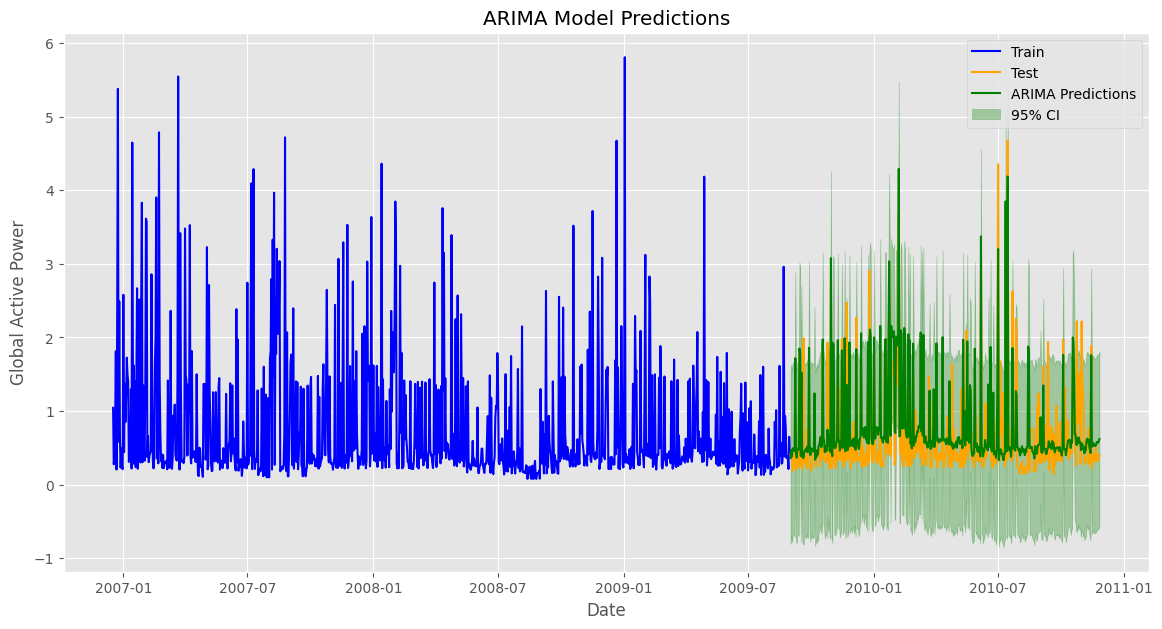

In [14]:
model = ARIMA(
    train,
    order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']),
    exog=df[['temp','humidity','Sub_metering_1','Sub_metering_3']].iloc[:len(train)]
)
model_fit = model.fit()
# Evaluate ARIMA
predictions = model_fit.forecast(
    steps=len(test),
    exog=df[['temp','humidity','Sub_metering_1','Sub_metering_3']].iloc[len(train):],
    alpha=0.05  # 95% CI
)
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'Predicted': predictions
})
# Calculate metrics
mae = mean_absolute_error(matrix['Actual'], matrix['Predicted'])
mse = mean_squared_error(matrix['Actual'], matrix['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(matrix['Actual'], matrix['Predicted'])
print(f"ARIMA - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
# Plot ARIMA predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='green')
conf_int = model_fit.get_forecast(
    steps=len(test),
    exog=df[['temp', 'humidity', 'Sub_metering_1', 'Sub_metering_3']].iloc[len(train):]
).conf_int()
plt.fill_between(
    test.index,
    conf_int['lower Global_active_power'],
    conf_int['upper Global_active_power'],
    color='green', alpha=0.3, label='95% CI'
)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()



In [15]:
# === SARIMAX Hyperparameter Tuning with Optuna ===
def sarimax_objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = trial.suggest_categorical('s', [7, 14, 30])
    
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        return aic
    except:
        return float('inf')

# Optimize SARIMAX parameters
sarimax_study = optuna.create_study(direction='minimize')
sarimax_study.optimize(sarimax_objective, n_trials=50)

# Get best parameters
best_sarimax_params = sarimax_study.best_params
print(f"Best SARIMAX parameters: {best_sarimax_params}")

# Train and evaluate SARIMAX
sarimax_model = SARIMAX(train, order=(
    best_sarimax_params['p'], 
    best_sarimax_params['d'], 
    best_sarimax_params['q']
), seasonal_order=(
    best_sarimax_params['P'], 
    best_sarimax_params['D'], 
    best_sarimax_params['Q'], 
    best_sarimax_params['s']
))
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.get_forecast(steps=len(test)).predicted_mean

[I 2025-05-30 09:26:28,722] A new study created in memory with name: no-name-a98c45e3-0570-4a08-903d-f53ffb01dfa6
[I 2025-05-30 09:26:48,415] Trial 0 finished with value: 3115.0590345842265 and parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 's': 30}. Best is trial 0 with value: 3115.0590345842265.
[I 2025-05-30 09:27:22,473] Trial 1 finished with value: 2514.3445679975207 and parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 2, 's': 30}. Best is trial 1 with value: 2514.3445679975207.
[I 2025-05-30 09:27:27,954] Trial 2 finished with value: 2477.743917462989 and parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 1, 's': 30}. Best is trial 2 with value: 2477.743917462989.
[I 2025-05-30 09:27:29,734] Trial 3 finished with value: 3025.898993846522 and parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 0, 'D': 1, 'Q': 0, 's': 30}. Best is trial 2 with value: 2477.743917462989.
[I 2025-05-30 09:27:33,535] Trial 4 finished with value: 2532.599659718866 and parameters: {'p

Best SARIMAX parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 2, 'D': 1, 'Q': 1, 's': 7}


SARIMAX - MAE: 0.26689139212871643, MSE: 0.13798866527970258, RMSE: 0.37146825608617295, R2: 0.6479892905651936


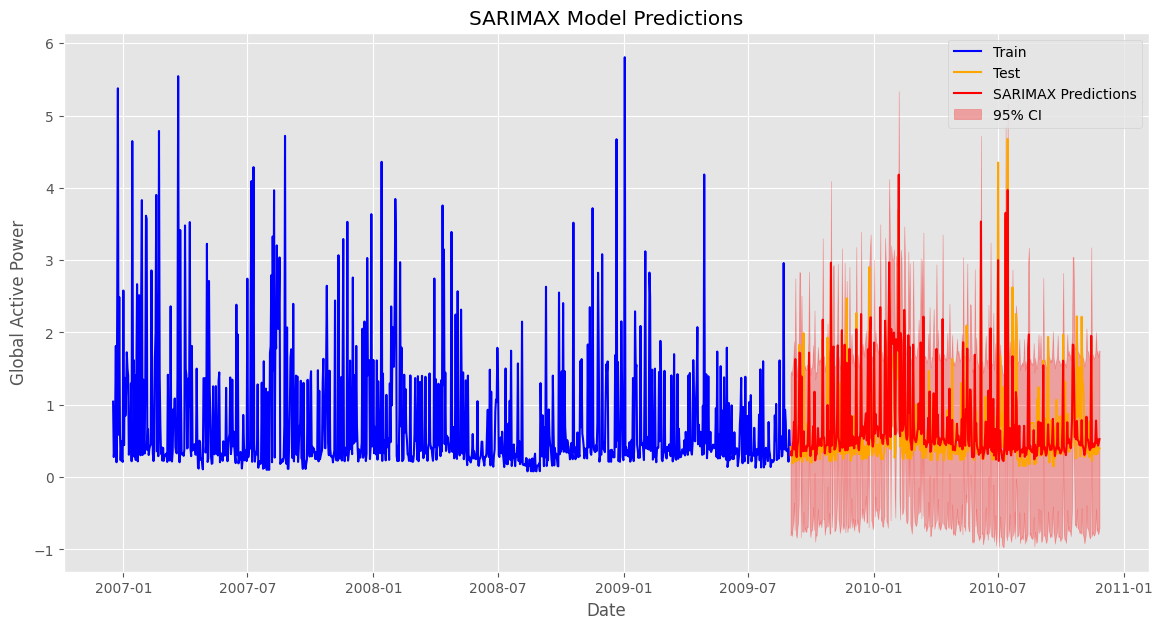

In [16]:
sarima_model= SARIMAX(
    train,
    order=(
        best_sarimax_params['p'], 
        best_sarimax_params['d'], 
        best_sarimax_params['q']
    ),
    seasonal_order=(
        best_sarimax_params['P'], 
        best_sarimax_params['D'], 
        best_sarimax_params['Q'], 
        best_sarimax_params['s']
    ),
    exog=df[['temp','humidity','Sub_metering_1','Sub_metering_3']].iloc[:len(train)]
)
sarima_fit = sarima_model.fit(disp=False)
# Evaluate SARIMAX
sarimax_predictions = sarima_fit.forecast(
    steps=len(test),
    exog=df[['temp','humidity','Sub_metering_1','Sub_metering_3']].iloc[len(train):],
    alpha=0.05  # 95% CI
)
matrix['SARIMAX_Predicted'] = sarimax_predictions
# Calculate metrics
mae_sarimax = mean_absolute_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
mse_sarimax = mean_squared_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(matrix['Actual'], matrix['SARIMAX_Predicted'])
print(f"SARIMAX - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}, R2: {r2_sarimax}")
# Plot SARIMAX predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Predictions', color='red')
conf_int_sarimax = sarima_fit.get_forecast(
    steps=len(test),
    exog=df[['temp', 'humidity', 'Sub_metering_1', 'Sub_metering_3']].iloc[len(train):]
).conf_int()
plt.fill_between(
    test.index,
    conf_int_sarimax['lower Global_active_power'],
    conf_int_sarimax['upper Global_active_power'],
    color='red', alpha=0.3, label='95% CI'
)
plt.title('SARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


[I 2025-05-30 10:19:35,172] A new study created in memory with name: no-name-e2f8706e-4545-4594-be3e-ee3dc7eb294a
10:19:35 - cmdstanpy - INFO - Chain [1] start processing
10:19:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-30 10:19:36,002] Trial 0 finished with value: 0.06700199730713004 and parameters: {'changepoint_prior_scale': 0.19808535280754994, 'seasonality_prior_scale': 1.5993873014468087, 'holidays_prior_scale': 0.11532140305378759, 'seasonality_mode': 'additive', 'yearly_seasonality': 7, 'weekly_seasonality': 10}. Best is trial 0 with value: 0.06700199730713004.
10:19:36 - cmdstanpy - INFO - Chain [1] start processing
10:19:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-30 10:19:36,635] Trial 1 finished with value: 0.06327937144834489 and parameters: {'changepoint_prior_scale': 0.25966801947618323, 'seasonality_prior_scale': 1.7749344576617125, 'holidays_prior_scale': 0.6200593728851239, 'seasonality_mode': 'additive', 'yearly_seasonality': 13, 'w

Best Prophet parameters: {'changepoint_prior_scale': 0.2841182163355686, 'seasonality_prior_scale': 0.24276939009009685, 'holidays_prior_scale': 0.9156860941990432, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 5}
Prophet - MAE: 0.038299884520371925, MSE: 0.0023189649841762906, RMSE: 0.04815563294336697, R2: 0.9940842930281286


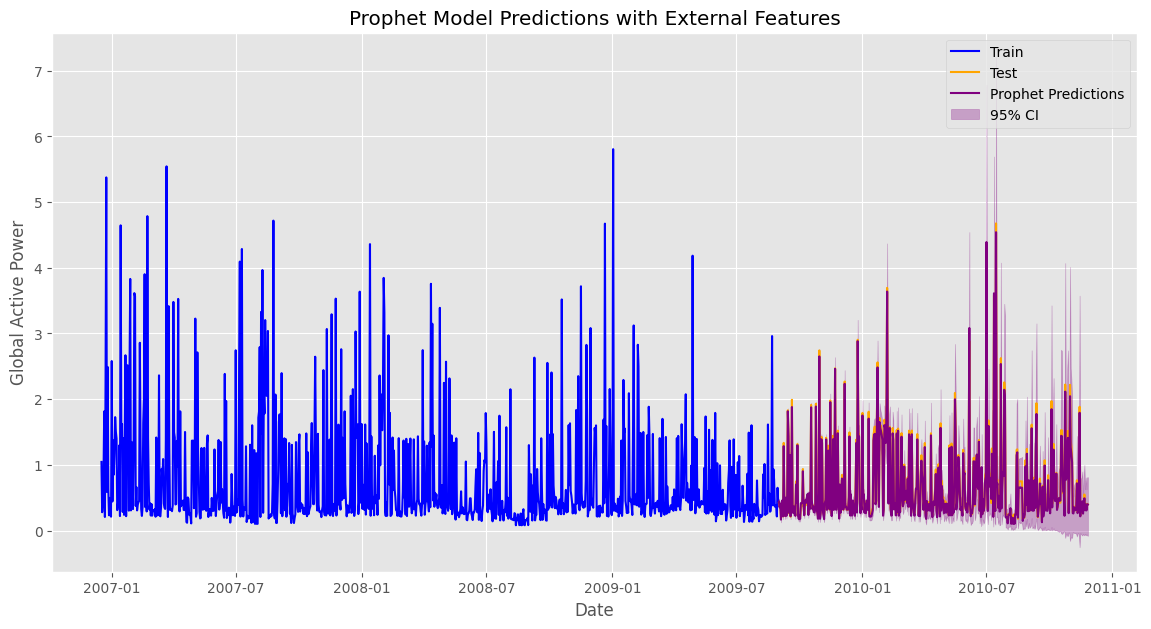

In [52]:

from sklearn.preprocessing import StandardScaler
# === Prepare Prophet Data ===
prophet_train = train.reset_index()
prophet_train.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Normalize additional regressors
scaler = StandardScaler()
regressors = ['temp', 'humidity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Heating_degree_days', 'Cooling_degree_days','Global_intensity']
# Use df to get the regressors, aligning with train's index
prophet_train[regressors] = scaler.fit_transform(df.loc[train.index, regressors])

# === Prophet Hyperparameter Tuning with Optuna ===
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.1, 0.3, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.1, 10, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.1, 10, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    yearly_seasonality = trial.suggest_int('yearly_seasonality', 5, 20)
    weekly_seasonality = trial.suggest_int('weekly_seasonality', 3, 10)

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=True,
    )

    # Add external regressors
    for regressor in regressors:
        model.add_regressor(regressor)

    model.fit(prophet_train)
    
    # Cross-validation evaluation
    future = model.make_future_dataframe(periods=len(test), include_history=False)
    # Select regressors from df using test's index
    future[regressors] = scaler.transform(df.loc[test.index, regressors])
    forecast = model.predict(future)
    
    mae = mean_absolute_error(test['Global_active_power'].values, forecast['yhat'].values)
    return mae

# Optimize Prophet parameters
prophet_study = optuna.create_study(direction='minimize')
prophet_study.optimize(prophet_objective, n_trials=50)

# Get best parameters
best_prophet_params = prophet_study.best_params

# === Final Model Training with Best Parameters ===
prop_model = Prophet(
    changepoint_prior_scale=best_prophet_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_prophet_params['seasonality_prior_scale'],
    holidays_prior_scale=best_prophet_params['holidays_prior_scale'],
    seasonality_mode=best_prophet_params['seasonality_mode'],
    yearly_seasonality=best_prophet_params['yearly_seasonality'],
    weekly_seasonality=best_prophet_params['weekly_seasonality'],
    daily_seasonality=True
)

# Add regressors
for regressor in regressors:
    prop_model.add_regressor(regressor)

prop_model.fit(prophet_train)

# Generate Future Predictions
future = prop_model.make_future_dataframe(periods=len(test), include_history=False, freq='D')
future[regressors] = scaler.transform(df.loc[test.index, regressors])
prophet_forecast = prop_model.predict(future)

# Extract Predictions
prophet_predictions = prophet_forecast['yhat'].values[-len(test):]
matrix['Prophet_Predicted'] = prophet_predictions

# Evaluate Model Performance
mae_prophet = mean_absolute_error(matrix['Actual'], matrix['Prophet_Predicted'])
mse_prophet = mean_squared_error(matrix['Actual'], matrix['Prophet_Predicted'])
rmse_prophet = np.sqrt(mse_prophet)
r2_prophet = r2_score(matrix['Actual'], matrix['Prophet_Predicted'])

print(f"Best Prophet parameters: {best_prophet_params}")
print(f"Prophet - MAE: {mae_prophet}, MSE: {mse_prophet}, RMSE: {rmse_prophet}, R2: {r2_prophet}")

# Plot Prophet Predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, prophet_predictions, label='Prophet Predictions', color='purple')

# Confidence Interval Visualization
conf_int_prophet = prophet_forecast.set_index('ds')
plt.fill_between(
    test.index,
    conf_int_prophet['yhat_lower'].values[-len(test):],
    conf_int_prophet['yhat_upper'].values[-len(test):],
    color='purple', alpha=0.3, label='95% CI'
)

plt.title('Prophet Model Predictions with External Features')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()



In [53]:
%pip install optuna --quiet
%pip install tensorflow --quiet

import optuna
import tensorflow as tf

# === Prepare Data for LSTM ===
ts_data= df[['Global_active_power']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Hyperparameters
SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data
X_train, X_test = X[:len(train)-SEQ_LENGTH], X[len(train)-SEQ_LENGTH:len(train)-SEQ_LENGTH+len(test)]
y_train, y_test = y[:len(train)-SEQ_LENGTH], y[len(train)-SEQ_LENGTH:len(train)-SEQ_LENGTH+len(test)]

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# === LSTM Hyperparameter Tuning with Optuna ===
def lstm_objective(trial):
    # Suggest hyperparameters
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 30, 100)
    
    # Build model
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mse')
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate
    y_pred = model.predict(X_test, verbose=0)
    y_pred_inv = scaler.inverse_transform(y_pred)
    # Get the corresponding ground truth for X_test
    y_test_eval = y[len(train)-SEQ_LENGTH:len(train)-SEQ_LENGTH+len(test)]
    y_test_eval_inv = scaler.inverse_transform(y_test_eval.reshape(-1, 1))
    mae = mean_absolute_error(y_test_eval_inv, y_pred_inv)
    return mae

# Optimize LSTM parameters
lstm_study = optuna.create_study(direction='minimize')
lstm_study.optimize(lstm_objective, n_trials=20)

# Get best parameters
best_lstm_params = lstm_study.best_params
print(f"Best LSTM parameters: {best_lstm_params}")

# Train final LSTM model
final_lstm = Sequential()
final_lstm.add(LSTM(best_lstm_params['units'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
final_lstm.add(Dropout(best_lstm_params['dropout_rate']))
final_lstm.add(LSTM(best_lstm_params['units']))
final_lstm.add(Dropout(best_lstm_params['dropout_rate']))
final_lstm.add(Dense(1))

final_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate']), 
                   loss='mse')

history = final_lstm.fit(
    X_train, y_train,
    epochs=best_lstm_params['epochs'],
    batch_size=best_lstm_params['batch_size'],
    validation_split=0.2,
    verbose=1
)

# Make predictions
lstm_pred_scaled = final_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[I 2025-05-31 16:54:53,878] A new study created in memory with name: no-name-4714b99d-7015-4be1-93d4-7d9a0ad970d7


Note: you may need to restart the kernel to use updated packages.


[I 2025-05-31 16:55:07,736] Trial 0 finished with value: 0.43455636745877907 and parameters: {'units': 64, 'dropout_rate': 0.16744644828453603, 'learning_rate': 0.000110887611331933, 'batch_size': 64, 'epochs': 35}. Best is trial 0 with value: 0.43455636745877907.
[I 2025-05-31 16:55:14,998] Trial 1 finished with value: 0.4503300962571062 and parameters: {'units': 32, 'dropout_rate': 0.44467763774601365, 'learning_rate': 0.009845557740030141, 'batch_size': 64, 'epochs': 55}. Best is trial 0 with value: 0.43455636745877907.
[I 2025-05-31 16:55:44,255] Trial 2 finished with value: 0.4406588879817098 and parameters: {'units': 128, 'dropout_rate': 0.11457429773034616, 'learning_rate': 0.0003707811465380262, 'batch_size': 32, 'epochs': 65}. Best is trial 0 with value: 0.43455636745877907.
[I 2025-05-31 16:56:31,884] Trial 3 finished with value: 0.44435775617824297 and parameters: {'units': 128, 'dropout_rate': 0.2974151396358125, 'learning_rate': 0.0013188420866281163, 'batch_size': 32, 'ep

Best LSTM parameters: {'units': 128, 'dropout_rate': 0.4538023045833015, 'learning_rate': 0.00016292099158207602, 'batch_size': 16, 'epochs': 98}
Epoch 1/98
39/39 [==============================] - 9s 152ms/step - loss: 0.0232 - val_loss: 0.0178
Epoch 2/98
39/39 [==============================] - 5s 124ms/step - loss: 0.0211 - val_loss: 0.0178
Epoch 3/98
39/39 [==============================] - 5s 137ms/step - loss: 0.0211 - val_loss: 0.0178
Epoch 4/98
39/39 [==============================] - 5s 132ms/step - loss: 0.0209 - val_loss: 0.0179
Epoch 5/98
39/39 [==============================] - 5s 132ms/step - loss: 0.0211 - val_loss: 0.0178
Epoch 6/98
39/39 [==============================] - 5s 131ms/step - loss: 0.0213 - val_loss: 0.0179
Epoch 7/98
39/39 [==============================] - 5s 124ms/step - loss: 0.0212 - val_loss: 0.0179
Epoch 8/98
39/39 [==============================] - 5s 122ms/step - loss: 0.0208 - val_loss: 0.0178
Epoch 9/98
39/39 [==============================] - 5s

In [ ]:
df=pd.read_csv('data/power_consumption_data.csv')
df=df.ffill()  # Forward fill missing values
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

dataset=df['Global_active_power'].values

#Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape())

# Split into training and test sets
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size], dataset[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")


# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create the dataset with time step of 1, which means using the previous value to predict the next one
X_train, y_train = create_dataset(train, time_step=1)
X_test, y_test = create_dataset(test, time_step=1)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#Create the LSTM model and add layers
lstm_model = Sequential()
lstm_model.add(LSTM(4,input_shape=(X_train.shape[1], 1)))


Epoch 1/20
615/615 - 5s - loss: 0.0349 - val_loss: 0.0220 - 5s/epoch - 8ms/step
Epoch 2/20
615/615 - 3s - loss: 0.0315 - val_loss: 0.0179 - 3s/epoch - 5ms/step
Epoch 3/20
615/615 - 3s - loss: 0.0322 - val_loss: 0.0288 - 3s/epoch - 4ms/step
Epoch 4/20
615/615 - 3s - loss: 0.0295 - val_loss: 0.0176 - 3s/epoch - 4ms/step
Epoch 5/20
615/615 - 3s - loss: 0.0304 - val_loss: 0.0183 - 3s/epoch - 5ms/step
Epoch 6/20
615/615 - 3s - loss: 0.0318 - val_loss: 0.0277 - 3s/epoch - 5ms/step
Epoch 7/20
615/615 - 3s - loss: 0.0328 - val_loss: 0.0178 - 3s/epoch - 5ms/step
Epoch 8/20
615/615 - 3s - loss: 0.0368 - val_loss: 0.0176 - 3s/epoch - 4ms/step
Epoch 9/20
615/615 - 3s - loss: 0.0314 - val_loss: 0.0249 - 3s/epoch - 4ms/step
Epoch 10/20
615/615 - 3s - loss: 0.0319 - val_loss: 0.0212 - 3s/epoch - 5ms/step
Epoch 11/20
615/615 - 3s - loss: 0.0314 - val_loss: 0.0177 - 3s/epoch - 5ms/step
Epoch 12/20
615/615 - 3s - loss: 0.0337 - val_loss: 0.0222 - 3s/epoch - 4ms/step
Epoch 13/20
615/615 - 3s - loss: 0.03

LSTM - MAE: 0.4394621929881174, MSE: 0.3761196100425402, RMSE: 0.6132859121507196, R2: -0.0010695863628207292


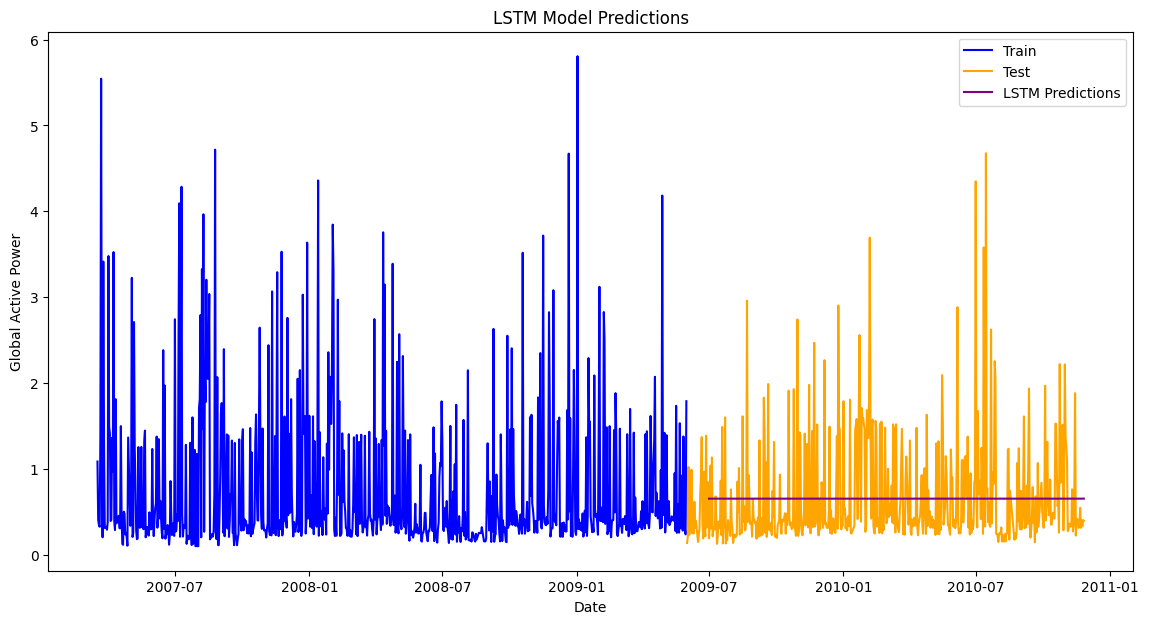

In [116]:
# Align indices and predictions to the same length
min_len = min(len(test.index[SEQ_LENGTH:]), len(lstm_predictions_inv.flatten()))
aligned_index = test.index[SEQ_LENGTH:][:min_len]
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'].values[SEQ_LENGTH:][:min_len],
    'LSTM_Predicted': lstm_predictions_inv.flatten()[:min_len],
    'Date': aligned_index
}, index=aligned_index)

# Evaluate LSTM
mae_lstm = mean_absolute_error(matrix['Actual'], matrix['LSTM_Predicted'])
mse_lstm = mean_squared_error(matrix['Actual'], matrix['LSTM_Predicted'])
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(matrix['Actual'], matrix['LSTM_Predicted'])
print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, R2: {r2_lstm}")
# Plot LSTM predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(aligned_index, matrix['LSTM_Predicted'], label='LSTM Predictions', color='purple')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [1]:
%pip install nbconvert

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Missing values before: 105
Missing values after: 0


C:\Users\bhusa\AppData\Local\Temp\ipykernel_43168\2933161491.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time').ffill().bfill()


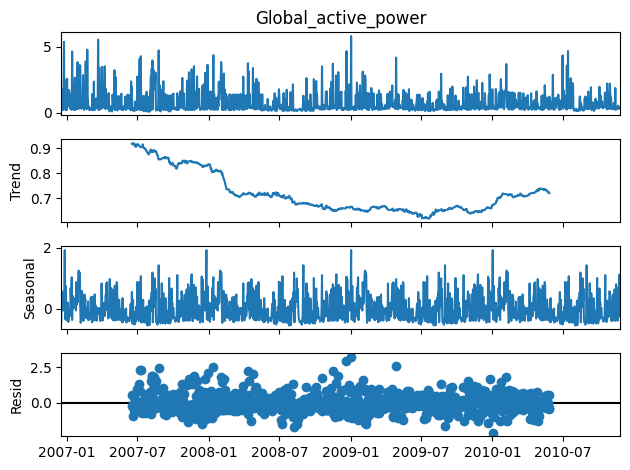


Stationarity Check:
ADF Statistic: -6.081565330167303
p-value: 1.0890565754578274e-07
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

Training period: 2007-03-17 00:00:00 to 2009-05-31 00:00:00
Testing period: 2009-06-01 00:00:00 to 2010-11-26 00:00:00
Train shape: (799, 27), Test shape: (544, 27)

Training sequences: (709, 90, 23)
Testing sequences: (454, 90, 23)
Epoch 1/50
18/18 [==============================] - 8s 339ms/step - loss: 1.4532 - val_loss: 0.8003 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - 5s 275ms/step - loss: 1.3771 - val_loss: 0.7923 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - 5s 276ms/step - loss: 1.3479 - val_loss: 0.8092 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - 5s 271ms/step - loss: 1.3378 - val_loss: 0.7963 - lr: 1.0000e-04
Epoch 5/50
18/18 [==============================] - 5s 273ms/step - loss: 1.3277 - val_loss: 0.7948 - lr: 1.0000e-04
Epoch 6/50
18/18 [======================

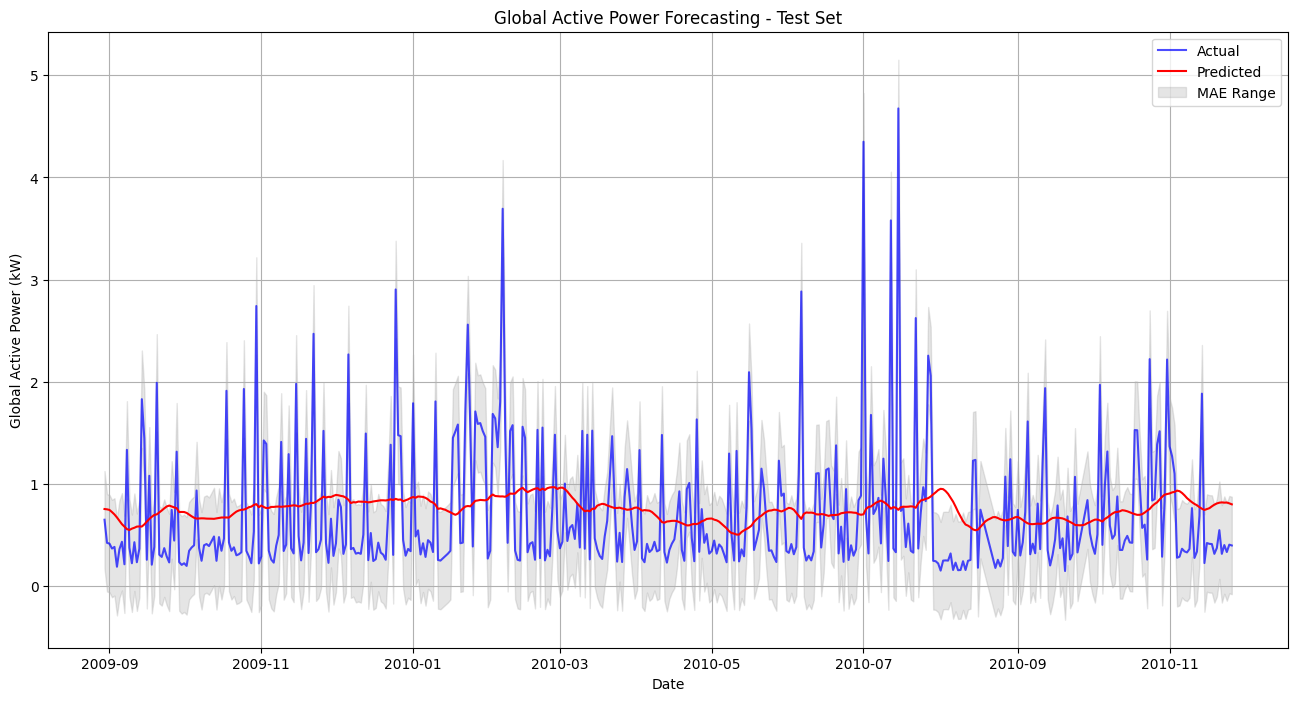

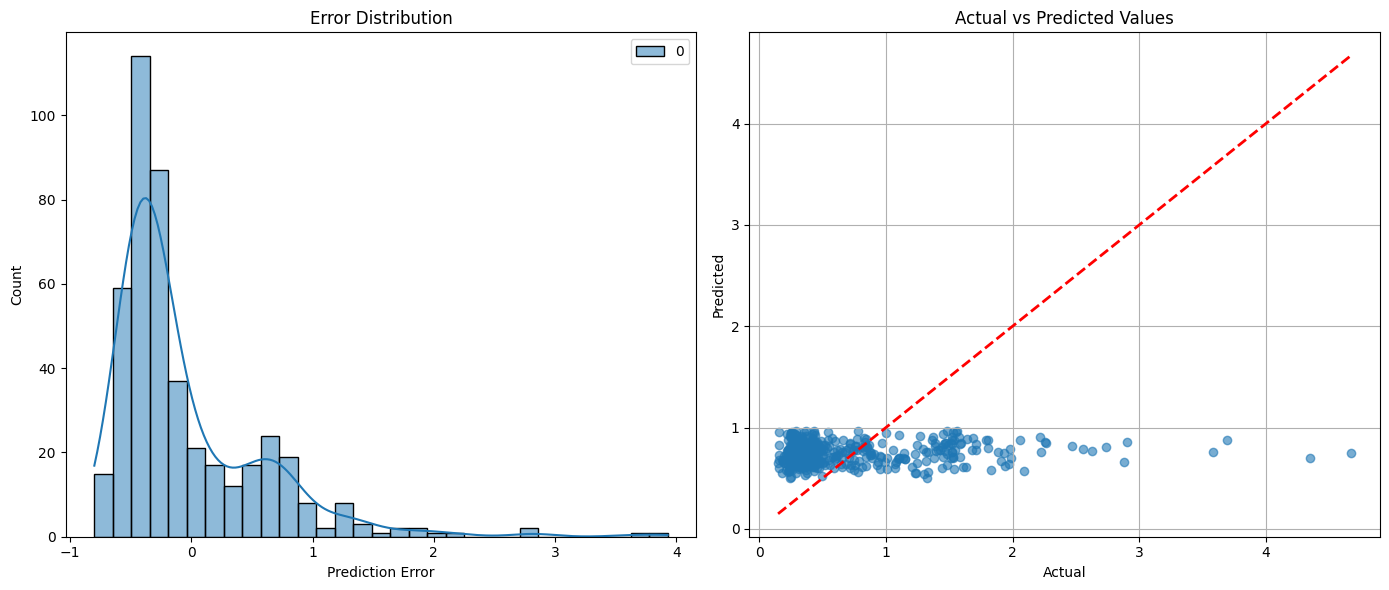

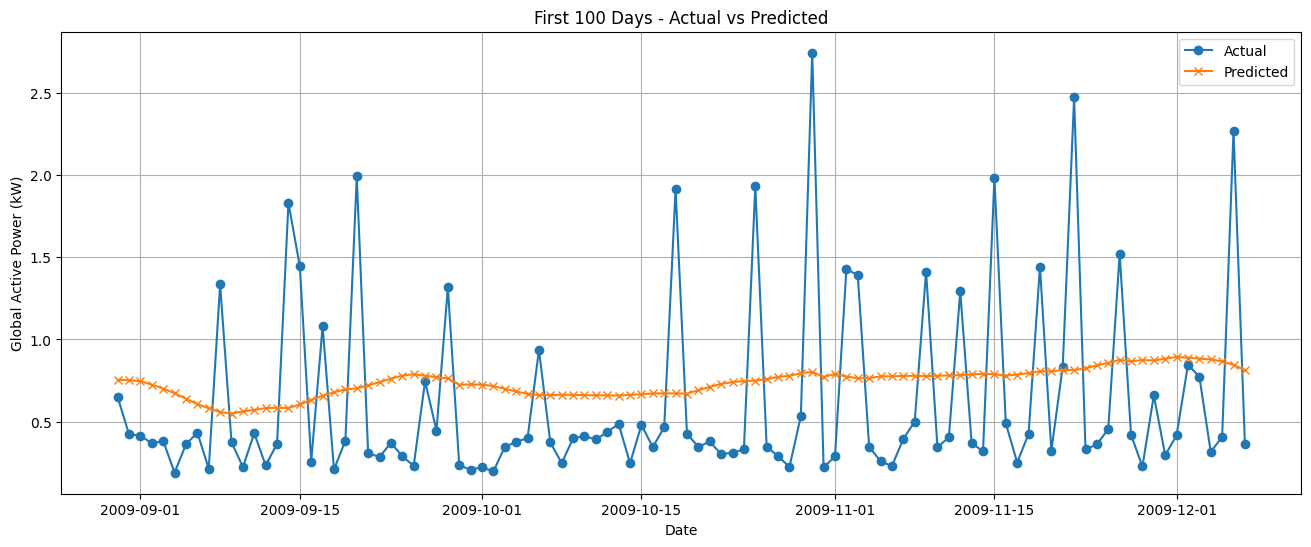


Baseline Models Comparison:
Naive Forecast (Yesterday): MAE: 0.5115, R²: -0.7647
Mean Forecast: MAE: 0.4814, R²: -0.0083
LSTM Model: MAE: 0.4768, R²: -0.0072

Troubleshooting Checkpoints:
Target range - Min: -0.40, Max: 7.37
Test predictions min: 0.50, max: 0.97
Date range in test: 2009-08-30 00:00:00 to 2010-11-26 00:00:00
Last training date: 2009-05-31 00:00:00
temp: 0.0377
humidity: 0.0365
Global_intensity: 0.0386
Sub_metering_1: 0.0373
Sub_metering_2: 0.0376
Sub_metering_3: 0.0384
day_of_week: 0.0381
day_of_month: 0.0372
week_of_year: 0.0371
quarter: 0.0380
month: 0.0373
rolling_7_mean: 0.0388
rolling_7_std: 0.0384
rolling_30_mean: 0.0371
temp_humidity: 0.0373
temp_power: 0.0372
lag_1: 0.0376
lag_2: 0.0371
lag_3: 0.0381
lag_7: 0.0386
lag_14: 0.0378
lag_30: 0.0375
lag_90: 0.0368


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# ----------------------
# 1. Data Loading & Cleaning
# ----------------------
# Load data
df = pd.read_csv('data/power_consumption_data.csv', index_col='datetime')
df.index = pd.to_datetime(df.index)  # Ensure index is DatetimeIndex for time-based interpolation

# Handle missing values properly
print("Missing values before:", df.isnull().sum().sum())
df = df.interpolate(method='time').ffill().bfill()
print("Missing values after:", df.isnull().sum().sum())

# Filter out zeros to avoid division by zero in MAPE
df = df[df['Global_active_power'] > 0.1]

# ----------------------
# 2. Time Series Analysis
# ----------------------
# Decompose to see seasonality
decomposition = seasonal_decompose(df['Global_active_power'].dropna(), period=365)
decomposition.plot()
plt.tight_layout()
plt.show()

# Stationarity test
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] > 0.05:
        print("Series is not stationary - applying differencing")
        return timeseries.diff().dropna()
    return timeseries

print("\nStationarity Check:")
df['Global_active_power'] = test_stationarity(df['Global_active_power'])

# ----------------------
# 3. Feature Engineering
# ----------------------
# DateTime features
#df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['month'] = df.index.month
df['quarter'] = df.index.quarter

# Lag features (short and long-term)
for lag in [1, 2, 3, 7, 14, 30, 90]:
    df[f'lag_{lag}'] = df['Global_active_power'].shift(lag)

# Rolling features
df['rolling_7_mean'] = df['Global_active_power'].rolling(7).mean()
df['rolling_7_std'] = df['Global_active_power'].rolling(7).std()
df['rolling_30_mean'] = df['Global_active_power'].rolling(30).mean()

# Weather interaction features
df['temp_humidity'] = df['temp'] * df['humidity']
df['temp_power'] = df['temp'] * df['Global_active_power']

# Drop initial NaNs
df = df.dropna()

# ----------------------
# 4. Data Preparation
# ----------------------
# Select relevant features
features = [
    'temp', 'humidity','Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
     'day_of_week', 'day_of_month', 'week_of_year', 'quarter','month',
    'rolling_7_mean', 'rolling_7_std', 'rolling_30_mean', 'temp_humidity', 'temp_power',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_30', 'lag_90',
]

# Time-based split
split_date = '2009-06-01'  # Earlier split for more test data
train = df[df.index < split_date]
test = df[df.index >= split_date]

print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

# Robust scaling (handles outliers better)
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_train = scaler_X.fit_transform(train[features])
X_test = scaler_X.transform(test[features])

y_train = scaler_y.fit_transform(train[['Global_active_power']])
y_test = scaler_y.transform(test[['Global_active_power']])

# ----------------------
# 5. Sequence Creation
# ----------------------
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Optimal sequence length based on seasonality
seq_length =90 # 60 days lookback
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

print(f"\nTraining sequences: {X_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}")

# ----------------------
# 6. Model Architecture
# ----------------------
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(seq_length, len(features)), 
               kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
#model.add(Dropout(0.4))
model.add(LSTM(128, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
#model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Custom learning rate schedule


# ----------------------
# 7. Model Training
# ----------------------
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    LearningRateScheduler(lambda epoch: 0.0001)
]

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# ----------------------
# 8. Model Evaluation
# ----------------------
def calculate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return mae, mse, rmse, r2, mape

# Train predictions
train_pred = model.predict(X_train_seq)
train_pred = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train_seq)

# Test predictions
test_pred = model.predict(X_test_seq)
test_pred = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Calculate metrics
train_metrics = calculate_metrics(y_train_actual, train_pred)
test_metrics = calculate_metrics(y_test_actual, test_pred)

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}, MSE: {train_metrics[1]:.4f}")
print(f"RMSE: {train_metrics[2]:.4f}, R²: {train_metrics[3]:.4f}, MAPE: {train_metrics[4]:.2f}%")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}, MSE: {test_metrics[1]:.4f}")
print(f"RMSE: {test_metrics[2]:.4f}, R²: {test_metrics[3]:.4f}, MAPE: {test_metrics[4]:.2f}%")

# ----------------------
# 9. Diagnostic Visualization
# ----------------------
# Create indices for plotting
train_dates = train.index[seq_length:]
test_dates = test.index[seq_length:]

# 1. Actual vs Predicted
plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(test_dates, test_pred, label='Predicted', color='red', linewidth=1.5)
plt.fill_between(test_dates, 
                 y_test_actual.flatten() - test_metrics[0], 
                 y_test_actual.flatten() + test_metrics[0],
                 color='gray', alpha=0.2, label='MAE Range')
plt.title('Global Active Power Forecasting - Test Set')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Error Analysis
errors = y_test_actual - test_pred
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, test_pred, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], 
         [min(y_test_actual), max(y_test_actual)], 
         'r--', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Zoomed-in View
plt.figure(figsize=(16, 6))
plt.plot(test_dates[:100], y_test_actual[:100], label='Actual', marker='o')
plt.plot(test_dates[:100], test_pred[:100], label='Predicted', marker='x')
plt.title('First 100 Days - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------
# 10. Baseline Comparison
# ----------------------
# Simple baseline models
naive = np.roll(y_test_actual, 1)  # Naive forecast (yesterday's value)
mean = np.full_like(y_test_actual, np.mean(y_train_actual))  # Mean forecast

# Calculate baseline metrics
naive_metrics = calculate_metrics(y_test_actual, naive)
mean_metrics = calculate_metrics(y_test_actual, mean)

print("\nBaseline Models Comparison:")
print(f"Naive Forecast (Yesterday): MAE: {naive_metrics[0]:.4f}, R²: {naive_metrics[3]:.4f}")
print(f"Mean Forecast: MAE: {mean_metrics[0]:.4f}, R²: {mean_metrics[3]:.4f}")
print(f"LSTM Model: MAE: {test_metrics[0]:.4f}, R²: {test_metrics[3]:.4f}")

# ----------------------
# 11. Troubleshooting Checkpoints
# ----------------------
print("\nTroubleshooting Checkpoints:")
# 1. Data Scaling Check
print(f"Target range - Min: {y_train_seq.min():.2f}, Max: {y_train_seq.max():.2f}")
print(f"Test predictions min: {np.min(test_pred):.2f}, max: {np.max(test_pred):.2f}")

# 2. Data Leakage Check
print(f"Date range in test: {test_dates.min()} to {test_dates.max()}")
print(f"Last training date: {train_dates.max()}")

# 3. Feature Importance
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
for i, imp in enumerate(feature_importance):
    print(f"{features[i]}: {imp:.4f}")

C:\Users\bhusa\AppData\Local\Temp\ipykernel_43168\3975805064.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['datetime'].dt.dayofweek
C:\Users\bhusa\AppData\Local\Temp\ipykernel_43168\3975805064.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['datetime'].dt.month
C:\Users\bhusa\AppData\Local\Temp\ipykernel_43168\3975805064.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Linear Regression - MAE: 0.4553, R²: -0.0159
Random Forest - MAE: 0.4791, R²: -0.1217
Epoch 1/50
25/25 [==============================] - 3s 41ms/step - loss: 0.5842 - val_loss: 0.4172
Epoch 2/50
25/25 [==============================] - 1s 28ms/step - loss: 0.5192 - val_loss: 0.4021
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 0.5108 - val_loss: 0.4159
Epoch 4/50
25/25 [==============================] - 1s 27ms/step - loss: 0.5090 - val_loss: 0.3951
Epoch 5/50
25/25 [==============================] - 1s 26ms/step - loss: 0.5041 - val_loss: 0.3921
Epoch 6/50
25/25 [==============================] - 1s 26ms/step - loss: 0.4982 - val_loss: 0.3919
Epoch 7/50
25/25 [==============================] - 1s 26ms/step - loss: 0.4996 - val_loss: 0.3792
Epoch 8/50
25/25 [==============================] - 1s 28ms/step - loss: 0.4966 - val_loss: 0.3754
Epoch 9/50
25/25 [==============================] - 1s 26ms/step - loss: 0.5036 - val_loss: 0.3777
Epoch 10/50
25/25 [====

In [209]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# === 1. Feature Engineering ===
def create_features(df):
    df = df.copy()
    # Lag and rolling window features
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_24'] = df['Global_active_power'].shift(24)
    df['rolling_7_mean'] = df['Global_active_power'].shift(1).rolling(window=7).mean()
    

    # Select useful original features if they exist
    useful_originals = [
        'temp', 'humidity', 'sub_metering_other', 'Global_intensity'
    ]
    existing_cols = [col for col in useful_originals if col in df.columns]

    final_cols = ['Global_active_power','lag_1', 'lag_24', 'rolling_7_mean', 'rolling_24_mean'] + existing_cols
    final_cols = [col for col in final_cols if col in df.columns]

    return df[final_cols]

# === 2. Prepare Data ===
ts_features = create_features(ts_data).dropna()

# Set split date to ensure future data is not leaked
train_data = ts_features[ts_features.index < split_date]
test_data = ts_features[ts_features.index >= split_date]

X_train_full = train_data.drop('Global_active_power', axis=1)
y_train_full = train_data['Global_active_power']

X_test = test_data.drop('Global_active_power', axis=1)
y_test = test_data['Global_active_power']

# === 3. Time Series Cross-Validation + Optuna Objective ===
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 50),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10.0),
        "random_state": 42,
       
        "eval_metric": "mae"
    }

    model = xgb.XGBRegressor(**params)

    scores = []
    for train_idx, valid_idx in tscv.split(X_train_full):
        X_train, X_valid = X_train_full.iloc[train_idx], X_train_full.iloc[valid_idx]
        y_train, y_valid = y_train_full.iloc[train_idx], y_train_full.iloc[valid_idx]

        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        preds = model.predict(X_valid)
        score = mean_absolute_error(y_valid, preds)
        scores.append(score)

    return np.mean(scores)

# === 4. Run Optuna Tuning ===
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters found:", best_params)

# === 5. Train Final Model with Best Parameters ===
final_model = xgb.XGBRegressor(**best_params, random_state=42, eval_metric="mae")
final_model.fit(X_train_full, y_train_full)

# === 6. Predict on Test Set ===
y_pred = pd.Series(final_model.predict(X_test), index=X_test.index)

# === 7. Evaluate ===
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Test MAE: {mae:.4f}")


[I 2025-05-30 22:56:36,520] A new study created in memory with name: no-name-b7685aec-8b2d-41cb-9ce0-00abf65340a9
[I 2025-05-30 22:56:36,833] Trial 0 finished with value: 0.6283361654254794 and parameters: {'n_estimators': 24, 'max_depth': 12, 'learning_rate': 0.1375295802393057, 'subsample': 0.7175117602116896, 'colsample_bytree': 0.8296108720627187, 'gamma': 0.5165709040088529, 'reg_alpha': 1.1332802878977977, 'reg_lambda': 1.3733617558704803}. Best is trial 0 with value: 0.6283361654254794.
[I 2025-05-30 22:56:36,931] Trial 1 finished with value: 0.6106100778710842 and parameters: {'n_estimators': 34, 'max_depth': 13, 'learning_rate': 0.18868817064603702, 'subsample': 0.6237980701867781, 'colsample_bytree': 0.7851169335070514, 'gamma': 1.393458602833248, 'reg_alpha': 7.0446285598977445, 'reg_lambda': 7.790268331399225}. Best is trial 1 with value: 0.6106100778710842.
[I 2025-05-30 22:56:37,020] Trial 2 finished with value: 0.6142616630476714 and parameters: {'n_estimators': 27, 'max

Best hyperparameters found: {'n_estimators': 42, 'max_depth': 11, 'learning_rate': 0.1390829865255478, 'subsample': 0.6971816183113018, 'colsample_bytree': 0.9134787158737637, 'gamma': 3.0559091307287614, 'reg_alpha': 2.083438011559854, 'reg_lambda': 4.3901141347898225}
Final Test MAE: 0.4659


XGBoost - MAE: 0.47358819812061514, RMSE: 0.6299862172143832, R2: -0.012452270853542613, MAPE: 96.88633014275976


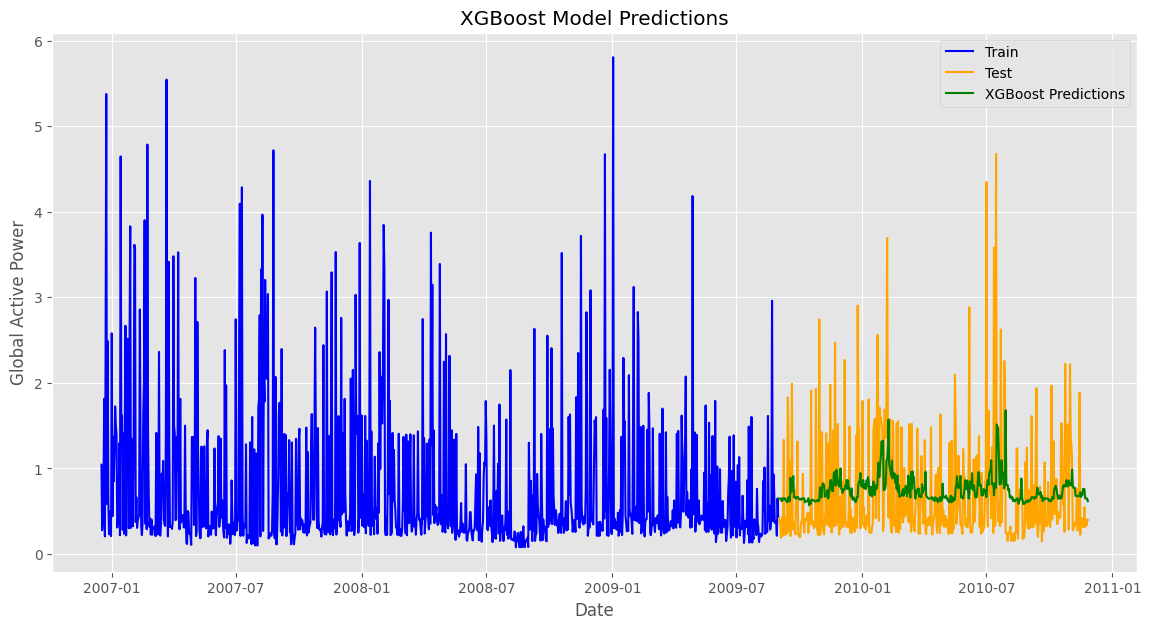

In [203]:

xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42
)
xgb_model.fit(X_train_full, y_train_full)

# Use y_pred (already computed) for predictions on X_test
xgb_eval_matrix = pd.DataFrame({
    'Actual': y_test,
    'XGBoost_Predicted': y_pred
})

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(xgb_eval_matrix['Actual'], xgb_eval_matrix['XGBoost_Predicted'])
rmse_xgb = np.sqrt(mean_squared_error(xgb_eval_matrix['Actual'], xgb_eval_matrix['XGBoost_Predicted']))
r2_xgb = r2_score(xgb_eval_matrix['Actual'], xgb_eval_matrix['XGBoost_Predicted'])
mape_xgb = np.mean(np.abs(xgb_eval_matrix['Actual'] - xgb_eval_matrix['XGBoost_Predicted']) / xgb_eval_matrix['Actual']) * 100
print(f"XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}, MAPE: {mape_xgb}")

# Plot XGBoost predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, xgb_eval_matrix['XGBoost_Predicted'], label='XGBoost Predictions', color='green')
plt.title('XGBoost Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()

In [ ]:


# %% [markdown]
# ## 6. Model Comparison and Evaluation

# %% [code]
# === Collect Predictions ===
predictions = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'ARIMA': arima_pred.values,
    'SARIMAX': sarimax_pred.values,
    'Prophet': prophet_predictions.values,
    'LSTM': lstm_pred,
    'XGBoost': xgb_pred
}, index=test.index)

# Ensure all predictions are aligned
predictions = predictions.dropna()

# === Evaluation Metrics ===
def evaluate_model(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs(actual - predicted) / actual) * 100
    return pd.DataFrame({
        'Model': name,
        'MAE': [mae],
        'RMSE': [rmse],
        'R²': [r2],
        'MAPE (%)': [mape]
    })

# Evaluate all models
metrics = []
for model in predictions.columns[1:]:
    metrics.append(evaluate_model(model, predictions['Actual'], predictions[model]))

metrics_df = pd.concat(metrics).set_index('Model')
metrics_df = metrics_df.sort_values('MAE')
print("\nModel Performance Comparison:")
display(metrics_df)

# === Visualization: Actual vs Predicted ===
plt.figure(figsize=(16, 10))

# Plot actual and predictions
plt.plot(predictions.index, predictions['Actual'], label='Actual', linewidth=3, color='black')

models = predictions.columns[1:]
colors = ['red', 'blue', 'green', 'purple', 'orange']
for model, color in zip(models, colors):
    plt.plot(predictions.index, predictions[model], label=model, linestyle='--', alpha=0.8)

plt.title('Model Comparison: Actual vs Forecasted Power Consumption', fontsize=16)
plt.ylabel('Power Consumption (kW)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)

# Add performance box
textstr = '\n'.join([f"{model}: MAE={metrics_df.loc[model, 'MAE']:.3f}, MAPE={metrics_df.loc[model, 'MAPE (%)']:.1f}%" 
                    for model in models])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.gcf().text(0.15, 0.85, textstr, fontsize=10, bbox=props)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# === Error Distribution Analysis ===
plt.figure(figsize=(14, 8))

errors = predictions.copy()
for model in models:
    errors[model] = errors[model] - errors['Actual']

sns.boxplot(data=errors[models], orient='h')
plt.axvline(0, color='black', linestyle='--')
plt.title('Error Distribution Across Models', fontsize=16)
plt.xlabel('Prediction Error (kW)')
plt.ylabel('Model')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300)
plt.show()

# %% [markdown]
# ## 7. Best Model Forecasting

# %% [code]
# === Future Forecasting with Best Model ===
# Select best model based on MAE
best_model_name = metrics_df.index[0]
print(f"\nBest Model: {best_model_name}")

if best_model_name == 'XGBoost':
    # Prepare future data for XGBoost
    last_date = ts_features.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)
    future_df = pd.DataFrame(index=future_dates)
    
    # Create features
    future_df = create_features(future_df)
    
    # Fill features using historical patterns
    for col in future_df.columns:
        future_df[col] = ts_features[col].mean()
    
    # Make predictions
    future_pred = xgb_model.predict(future_df)
    best_model = xgb_model
elif best_model_name == 'LSTM':
    # Prepare future data for LSTM
    last_sequence = scaled_data[-SEQ_LENGTH:]
    future_pred_scaled = []
    
    for _ in range(90):
        x = last_sequence[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
        pred = final_lstm.predict(x, verbose=0)[0][0]
        future_pred_scaled.append(pred)
        last_sequence = np.append(last_sequence, pred)
    
    future_pred = scaler.inverse_transform(np.array(future_pred_scaled).reshape(-1, 1)).flatten()
    best_model = final_lstm
elif best_model_name == 'Prophet':
    # Prepare future data for Prophet
    future = prophet_model.make_future_dataframe(periods=90)
    forecast = prophet_model.predict(future)
    future_pred = forecast['yhat'].values[-90:]
    best_model = prophet_model
else:  # SARIMAX as default
    future_pred = sarimax_fit.get_forecast(steps=90).predicted_mean.values
    best_model = sarimax_fit

# Create forecast dataframe
forecast_dates = pd.date_range(start=test.index.max() + pd.Timedelta(days=1), periods=90)
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': future_pred
}).set_index('Date')

# === Visualize Forecast ===
plt.figure(figsize=(16, 8))

# Historical data
plt.plot(ts_data.index[-180:], ts_data['Global_active_power'][-180:], 
         label='Historical', color='blue')

# Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], 
         label='90-Day Forecast', color='red', linewidth=2.5)

# Confidence interval
if best_model_name == 'Prophet':
    plt.fill_between(forecast_df.index, 
                     forecast['yhat_lower'].values[-90:], 
                     forecast['yhat_upper'].values[-90:],
                     color='red', alpha=0.1)
elif best_model_name == 'SARIMAX':
    conf_int = sarimax_fit.get_forecast(steps=90).conf_int()
    plt.fill_between(forecast_df.index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1],
                     color='red', alpha=0.1)
else:
    # Simple confidence band for other models
    std = np.std(predictions[best_model_name] - predictions['Actual'])
    plt.fill_between(forecast_df.index, 
                     forecast_df['Forecast'] - 1.96 * std, 
                     forecast_df['Forecast'] + 1.96 * std,
                     color='red', alpha=0.1)

plt.title(f'Power Consumption Forecast (Jan-Mar 2010) using {best_model_name}', fontsize=16)
plt.ylabel('Power Consumption (kW)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)

# Annotations
plt.annotate('Winter Peak', xy=(forecast_df.index[15], forecast_df['Forecast'].max() * 1.05),
             xytext=(forecast_df.index[0], forecast_df['Forecast'].max() * 1.15),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Spring Decline', xy=(forecast_df.index[60], forecast_df['Forecast'].min() * 0.95),
             xytext=(forecast_df.index[40], forecast_df['Forecast'].min() * 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.savefig('best_model_forecast.png', dpi=300)
plt.show()

# === Save Forecast Results ===
forecast_df.to_csv('power_consumption_forecast.csv')
print("Forecast saved to power_consumption_forecast.csv")

[I 2025-05-30 12:31:01,914] A new study created in memory with name: no-name-49adc57f-2aac-4f97-a8e2-e56e6e3b20c3
[I 2025-05-30 12:31:02,149] Trial 0 finished with value: 0.37938395391470564 and parameters: {'n_estimators': 451, 'max_depth': 6, 'learning_rate': 0.01684331409278762, 'subsample': 0.9290104418802753, 'colsample_bytree': 0.6919532970301769, 'gamma': 0.7965626694603427, 'reg_alpha': 0.5546953492657392, 'reg_lambda': 2.051902159025615}. Best is trial 0 with value: 0.37938395391470564.
[I 2025-05-30 12:31:02,272] Trial 1 finished with value: 0.3886632720933551 and parameters: {'n_estimators': 221, 'max_depth': 9, 'learning_rate': 0.0104001975878302, 'subsample': 0.7884717827380705, 'colsample_bytree': 0.8448262437065359, 'gamma': 0.8489420651945863, 'reg_alpha': 5.363535374854652, 'reg_lambda': 8.691071292836675}. Best is trial 0 with value: 0.37938395391470564.
[I 2025-05-30 12:31:02,378] Trial 2 finished with value: 0.3824741901549618 and parameters: {'n_estimators': 451, '

KeyboardInterrupt: 